In [21]:
import numpy as np
import torch
from torch import nn
import LightPipes as lp
import matplotlib.pyplot as plt
import os, sys, h5py
main_dir = os.path.abspath('../')
sys.path.append(main_dir)

from utils.functions import *
from utils.models.modalevaluator import ModalEvaluator


device = 'cuda:3'

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)


truncate_circle = False

Load the Modes and the derivatives

In [22]:
microlens = 20 #20x20
size = microlens

n_zernike_rows = 6
n_zernike = n_zernike_rows*(n_zernike_rows+1)//2

x = torch.linspace(-1,1,size)
y = torch.linspace(-1,1,size)

xx, yy = torch.meshgrid(x,y)

Make a custom wavefront...

Text(0.5, 1.0, 'True Wavefront Derivative')

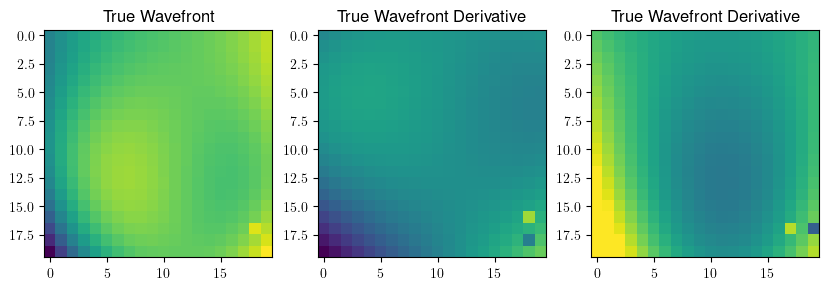

In [23]:
wavefront = torch.zeros(size,size)

decenter = [0.2,0.2] #lets say we're off center...

modes, mode_derivs = get_modes_and_derivs(decenter, xx, yy, n_zernike=n_zernike_rows, truncate_circle=False, pixel_basis = True)

mode_coeffs = torch.zeros((len(modes),1,1))


elements = np.arange(3,n_zernike)
np.random.shuffle(elements)
elements = elements[:3]
zer_coeffs = torch.randn(len(elements),1,1)

mode_coeffs[elements] = zer_coeffs
# mode_coeffs[n_zernike] = 1 #vortex

mode_coeffs[380] = 1 # we have some noise

wavefront = torch.sum(mode_coeffs * modes,dim=0)
wavefront_deriv = torch.sum(mode_coeffs * mode_derivs,dim=1)


fig,ax = plt.subplots(1,3,figsize=(10,5))

ax[0].imshow(wavefront); ax[0].set_title('True Wavefront')
ax[1].imshow(wavefront_deriv[0],vmax=1,vmin=-1); ax[1].set_title('True Wavefront Derivative')
ax[2].imshow(wavefront_deriv[1],vmax=1,vmin=-1); ax[2].set_title('True Wavefront Derivative')

## From here I show once we have gradients


In [24]:
sampled_gradient = wavefront_deriv.clone()
sampled_gradient[:,10,10] = np.nan

sampled_gradient+=torch.randn_like(sampled_gradient)*0.01 * torch.max(torch.nan_to_num(sampled_gradient))

num_inits = 25

evaller = ModalEvaluator(size=(size,size), initializations=num_inits, n_zernike_rows=n_zernike_rows, zern_transform=True,pixel_basis=True, device=device)

In [31]:
init_transX, init_transY = np.meshgrid(np.linspace(-.2, .2, 5), np.linspace(-.2, .2, 5))

init_rot, init_transX, init_transY = [0.]*num_inits, init_transX.flatten(), init_transY.flatten()

coeffs, history = evaller.fit(sampled_gradient, affine_initialization=[init_rot, init_transX, init_transY], epochs=12000, lr=3e-3, l1_reg=1e-3)

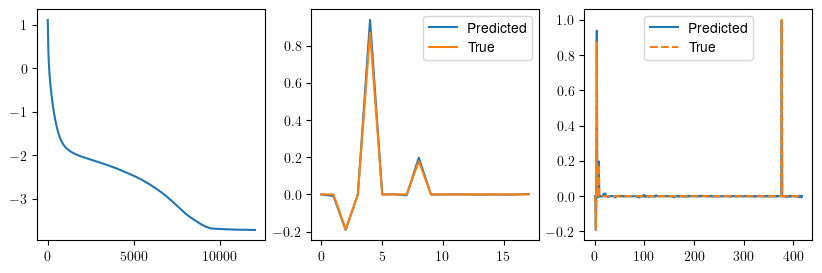

In [32]:
fig,ax = plt.subplots(1,3, figsize = (10,3))
ax[0].plot(np.log10(history['loss']))
ax[1].plot(coeffs['coefficients'][evaller.best_init,3:n_zernike].detach().cpu())
ax[1].plot(mode_coeffs[3:n_zernike,0,0])
ax[1].legend(['Predicted','True'])
ax[2].plot(coeffs['coefficients'][evaller.best_init,3:].detach().cpu())
ax[2].plot(mode_coeffs[3:,0,0],'--')
ax[2].legend(['Predicted','True'])

In [33]:
print(history['per_init_loss'])

[8.9043366e-05 8.8123066e-05 8.9437890e-05 8.8850655e-05 8.8971945e-05
 8.9359462e-05 8.8428249e-05 8.9187692e-05 8.9272267e-05 8.9322537e-05
 8.9184978e-05 9.0119982e-05 8.9898022e-05 8.8962566e-05 9.0117057e-05
 8.9392292e-05 9.2055649e-05 8.9756490e-05 8.9278758e-05 8.8904060e-05
 8.9438727e-05 8.8895009e-05 8.9020265e-05 8.9491135e-05 8.9214511e-05]


In [34]:
wavefront_pred, derivs_pred =  evaller.get_wavefront(coeffs, microlens_pitch=1)

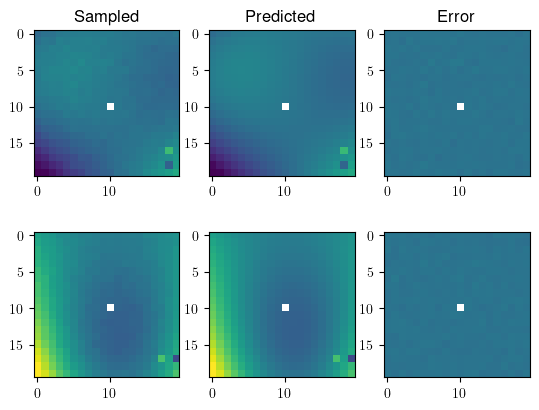

In [35]:
vmax = torch.nan_to_num(sampled_gradient).max()*.9
vmin = torch.nan_to_num(sampled_gradient).min()*.9

fig,ax = plt.subplots(2,3,dpi=100)
ax[0,0].imshow(sampled_gradient[0],vmax=vmax, vmin=vmin); ax[0,0].set_title('Sampled')
ax[0,1].imshow(derivs_pred[0],vmax=vmax, vmin=vmin); ax[0,1].set_title('Predicted')
ax[0,2].imshow(sampled_gradient[0]-derivs_pred[0],vmax=vmax, vmin=vmin); ax[0,2].set_title('Error')

ax[1,0].imshow(sampled_gradient[1],vmax=vmax, vmin=vmin)
ax[1,1].imshow(derivs_pred[1],vmax=vmax, vmin=vmin)
ax[1,2].imshow(sampled_gradient[1]-derivs_pred[1],vmax=vmax, vmin=vmin)

Text(0.5, 1.0, 'Error')

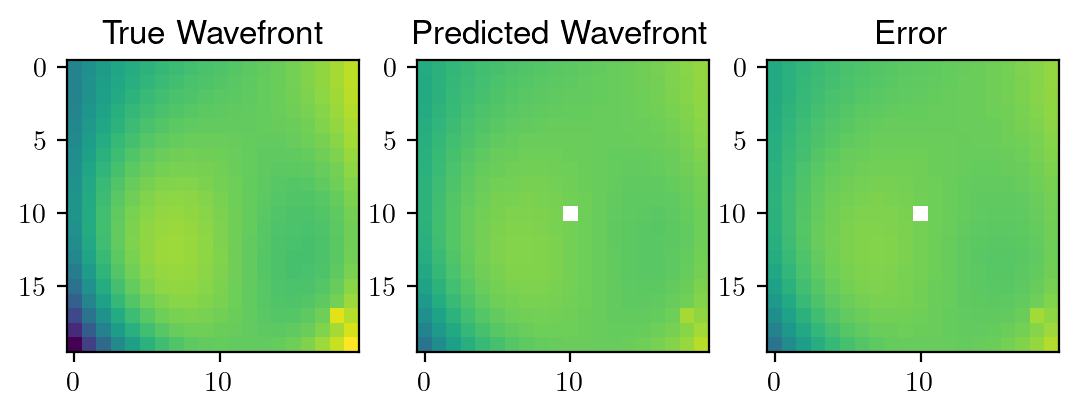

In [36]:
vmax = wavefront.max()
vmin = wavefront.min()

fig,ax = plt.subplots(1,3,dpi=200)
ax[0].imshow(wavefront,vmax=vmax,vmin=vmin); ax[0].set_title('True Wavefront')
ax[1].imshow(wavefront_pred,vmax=vmax,vmin=vmin); ax[1].set_title('Predicted Wavefront')
ax[2].imshow(wavefront-wavefront_pred,vmax=vmax,vmin=vmin); ax[2].set_title('Error')

#(wavefront_pred/wavefront).mean(), (wavefront_pred/wavefront).std()